In [7]:
import torch
import math


class LipschitzLinear(torch.nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = torch.nn.Parameter(torch.empty((out_features, in_features), requires_grad=True))
        self.bias = torch.nn.Parameter(torch.empty((out_features), requires_grad=True))
        self.c = torch.nn.Parameter(torch.empty((1), requires_grad=True))
        self.softplus = torch.nn.Softplus()
        self.initialize_parameters()

    def initialize_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        self.bias.data.uniform_(-stdv, stdv)

        # compute lipschitz constant of initial weight to initialize self.c
        W = self.weight.data
        W_abs_row_sum = torch.abs(W).sum(1)
        self.c.data = W_abs_row_sum.max()  # just a rough initialization

    def get_lipschitz_constant(self):
        return self.softplus(self.c)

    def forward(self, input):
        lipc = self.softplus(self.c)
        scale = lipc / torch.abs(self.weight).sum(1)
        scale = torch.clamp(scale, max=1.0)
        return torch.nn.functional.linear(input, self.weight * scale.unsqueeze(1), self.bias)


class lipmlp(torch.nn.Module):
    def __init__(self, dims):
        """
        dim[0]: input dim
        dim[1:-1]: hidden dims
        dim[-1]: out dim

        assume len(dims) >= 3
        """
        super().__init__()

        self.layers = torch.nn.ModuleList()
        for ii in range(len(dims) - 2):
            self.layers.append(LipschitzLinear(dims[ii], dims[ii + 1]))

        self.layer_output = LipschitzLinear(dims[-2], dims[-1])
        self.relu = torch.nn.ReLU()

    def get_lipschitz_loss(self):
        loss_lipc = 1.0
        for ii in range(len(self.layers)):
            loss_lipc = loss_lipc * self.layers[ii].get_lipschitz_constant()
        loss_lipc = loss_lipc * self.layer_output.get_lipschitz_constant()
        return loss_lipc

    def forward(self, x):
        for ii in range(len(self.layers)):
            x = self.layers[ii](x)
            x = self.relu(x)
        return self.layer_output(x)


# Example forward pass 
model = lipmlp([10, 20, 30, 40])
x = torch.randn(10, 10)
y = model(x)
print(y.shape)

# Example loss computation
# compute loss
# loss_sdf = loss_func(sdf0, gt0) + loss_func(sdf1, gt1) 
# loss_lipschitz = lam * model.get_lipschitz_loss()
# loss = loss_sdf + loss_lipschitz

torch.Size([10, 40])


INFO-VAE

In [2]:
import argparse
from argparse import Namespace

import lightning as L
import torch
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import WandbLogger

import wandb
from utility import Utility
from torch import optim
from datasettype import DatasetType
from callbacks import CustomCallbacks
import sys


def parse_args():
    if 'ipykernel' not in sys.modules:
        parser = argparse.ArgumentParser(description='Train an autoencoder')
        parser.add_argument('--z', type=int, default=32, help='Latent dimension size')
        parser.add_argument('--dataset', type=int, default=1, help='Database to use')
        parser.add_argument('--epochs', type=int, default=10, help='Number of epochs to train')
        parser.add_argument('--batch_size', type=int, default=32, help='Batch size')
        parser.add_argument('--num_workers', type=int, default=1, help='Number of workers for dataloader')
        parser.add_argument('--lr', type=float, default=1e-3, help='Learning rate')
        parser.add_argument('--limit_train_batches', type=float, default=1.0,
                            help='Fraction of training data to use per epoch')
        return parser.parse_args()
    else:
        return Namespace(z=32, dataset=1, epochs=10, batch_size=32, num_workers=1, lr=1e-3, limit_train_batches=0.1)


class MSE(torch.nn.Module):
    def __init__(self, beta, z_dim):
        super().__init__()
        self.beta = beta
        self.z_dim = z_dim

    def forward(self, input, target, z):
        if self.beta == 0:
            return torch.mean((input - target) ** 2)
        else:
            true_samples = torch.randn((200, self.z_dim), requires_grad=False, device=input.device)
            mmd = self.beta * compute_mmd(true_samples, z)
            return torch.mean((input - target) ** 2) + mmd

In [3]:
class Encoder(torch.nn.Module):
    def __init__(self, img_size: tuple, latent_dim: int = 10):
        channels, height, width = img_size
        z_dim = latent_dim

        super(Encoder, self).__init__()
        self.model = torch.nn.ModuleList([
            torch.nn.Conv2d(channels, 64, 4, 2, padding=1),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(64, 128, 4, 2, padding=1),
            torch.nn.LeakyReLU(),
            torch.nn.Flatten(),
            torch.nn.Linear(128 * (height // 4) * (height // 4), 1024),  # if h=64 -> 32768
            torch.nn.LeakyReLU(),
            torch.nn.Linear(1024, z_dim)
        ])

    def forward(self, x):
        for layer in self.model:
            x = layer(x)
        return x


class Decoder(torch.nn.Module):
    def __init__(self, img_size: tuple, latent_dim: int = 10):
        channels, height, width = img_size
        z_dim = latent_dim

        super(Decoder, self).__init__()
        self.model = torch.nn.ModuleList([
            torch.nn.Linear(z_dim, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 128 * (height // 4) * (height // 4)),
            torch.nn.ReLU(),
            torch.nn.Unflatten(1, (128, height // 4, height // 4)),
            torch.nn.ConvTranspose2d(128, 64, 4, 2, padding=1),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(64, channels, 4, 2, padding=1),
            torch.nn.Sigmoid()
        ])

    def forward(self, x):
        for layer in self.model:
            x = layer(x)
        return x


def compute_kernel(x, y):
    x_size = x.size(0)
    y_size = y.size(0)
    dim = x.size(1)
    x = x.unsqueeze(1)  # (x_size, 1, dim)
    y = y.unsqueeze(0)  # (1, y_size, dim)
    tiled_x = x.expand(x_size, y_size, dim)
    tiled_y = y.expand(x_size, y_size, dim)
    kernel_input = (tiled_x - tiled_y).pow(2).mean(2) / torch.tensor(dim, dtype=torch.float32)

    return torch.exp(-kernel_input)  # (x_size, y_size)


def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    mmd = x_kernel.mean() + y_kernel.mean() - 2 * xy_kernel.mean()
    return mmd



In [4]:
class AutoEncoder(L.LightningModule):
    def __init__(self, encoder: Encoder, decoder: Decoder, z_dim: int, lr: float, beta: float = 1.0):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.loss_func: MSE = MSE(beta, z_dim)
        self.lr = lr

        self.test_losses = []

        self.save_hyperparameters(ignore=["encoder", "decoder", "loss_func", "wandb"])
        # if wandb:
        #     wandb.config.update()

    def training_step(self, batch, batch_idx):
        x, y = batch  # x.shape: (200, 1, 64, 64), y.shape: (200, 1, 6)
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)

        loss = self.loss_func(x_reconstructed, x, z)

        self.log("train_loss", loss)
        return loss

    # validation step
    def validation_step(self, batch, batch_idx):
        x, y = batch
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        loss = self.loss_func(x_reconstructed, x, z)
        self.log("val_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

    def test_step(self, batch, batch_idx):
        x, y = batch
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        loss = self.loss_func(x_reconstructed, x, z)
        self.test_losses.append(loss)
        return {"test_loss": loss}

    def on_test_epoch_end(self):
        avg_loss = torch.stack(self.test_losses).mean()
        self.log("avg_test_loss", avg_loss)
        self.test_losses = []  # reset for the next epoch


wandb: Currently logged in as: oboii. Use `wandb login --relogin` to force relogin


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Python\Python39\lib\site-packages\lightning\pytorch\loggers\wandb.py:390: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params
--------------------------------------
0 | encoder   | Encoder | 6.6 M 
1 | decoder   | Decoder | 6.6 M 
2 | loss_func | MSE     | 0     
--------------------------------------
13.2 M    Trainable params
0         Non-trainable params
13.2 M    Total params
52.734    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Python\Python39\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
C:\Python\Python39\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 150: 'val_loss' reached 0.03200 (best 0.03200), saving model to 'C:\\GitHub\\Research-Experiments\\autoencoder\\wandb\\run-20240523_102444-ovbhcwbb\\files\\checkpoints\\epoch=0-step=150.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 300: 'val_loss' reached 0.02117 (best 0.02117), saving model to 'C:\\GitHub\\Research-Experiments\\autoencoder\\wandb\\run-20240523_102444-ovbhcwbb\\files\\checkpoints\\epoch=1-step=300.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 450: 'val_loss' reached 0.01647 (best 0.01647), saving model to 'C:\\GitHub\\Research-Experiments\\autoencoder\\wandb\\run-20240523_102444-ovbhcwbb\\files\\checkpoints\\epoch=2-step=450.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 600: 'val_loss' reached 0.01362 (best 0.01362), saving model to 'C:\\GitHub\\Research-Experiments\\autoencoder\\wandb\\run-20240523_102444-ovbhcwbb\\files\\checkpoints\\epoch=3-step=600.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 750: 'val_loss' reached 0.01232 (best 0.01232), saving model to 'C:\\GitHub\\Research-Experiments\\autoencoder\\wandb\\run-20240523_102444-ovbhcwbb\\files\\checkpoints\\epoch=4-step=750.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 900: 'val_loss' reached 0.01097 (best 0.01097), saving model to 'C:\\GitHub\\Research-Experiments\\autoencoder\\wandb\\run-20240523_102444-ovbhcwbb\\files\\checkpoints\\epoch=5-step=900.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 1050: 'val_loss' reached 0.01007 (best 0.01007), saving model to 'C:\\GitHub\\Research-Experiments\\autoencoder\\wandb\\run-20240523_102444-ovbhcwbb\\files\\checkpoints\\epoch=6-step=1050.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 1200: 'val_loss' reached 0.00959 (best 0.00959), saving model to 'C:\\GitHub\\Research-Experiments\\autoencoder\\wandb\\run-20240523_102444-ovbhcwbb\\files\\checkpoints\\epoch=7-step=1200.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 1350: 'val_loss' reached 0.00908 (best 0.00908), saving model to 'C:\\GitHub\\Research-Experiments\\autoencoder\\wandb\\run-20240523_102444-ovbhcwbb\\files\\checkpoints\\epoch=8-step=1350.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 1500: 'val_loss' reached 0.00861 (best 0.00861), saving model to 'C:\\GitHub\\Research-Experiments\\autoencoder\\wandb\\run-20240523_102444-ovbhcwbb\\files\\checkpoints\\epoch=9-step=1500.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=10` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Python\Python39\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       avg_test_loss       │    0.00925136636942625    │
└───────────────────────────┴───────────────────────────┘

avg_test_loss,▁
epoch,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
train_loss,█▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
val_loss,█▅▃▃▂▂▁▁▁▁
avg_test_loss,0.00925
epoch,10
train_loss,0.00781
trainer/global_step,1500
val_loss,0.00861


Run name: run-20240523_102444-ovbhcwbb


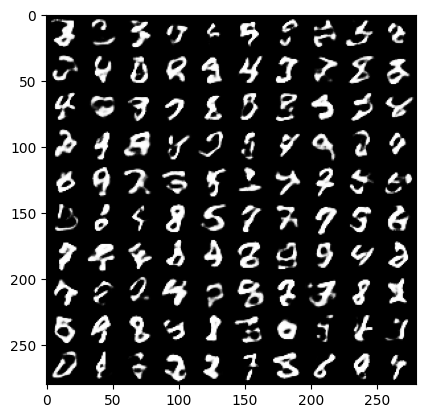

In [5]:
def train():
    args = parse_args()
    z_dim = args.z
    dataset = DatasetType(args.dataset)
    epochs = args.epochs
    batch_size = args.batch_size
    num_workers = args.num_workers
    lr = args.lr
    limit_train_batches = args.limit_train_batches

    torch.set_float32_matmul_precision('medium')

    data, im_shape, project_name = Utility.setup(dataset, batch_size, num_workers)

    wandb.init(project="info-vae", entity="oboii",
               tags=[f"z={z_dim}", f"lr={lr}", f"batch_size={batch_size}"],
               name=f"z={z_dim}_lr={lr}_batch_size={batch_size}_{wandb.util.generate_id()}")

    wandb_logger = WandbLogger()

    checkpoint_dir = f"{wandb.run.dir}/checkpoints"
    checkpoint_callback = ModelCheckpoint(dirpath=checkpoint_dir, save_top_k=1, verbose=True, monitor='val_loss',
                                          mode='min', save_last=True)

    encoder = Encoder(latent_dim=z_dim, img_size=im_shape)
    decoder = Decoder(latent_dim=z_dim, img_size=im_shape)

    autoencoder = AutoEncoder(encoder, decoder, z_dim, lr)

    # Train the model
    trainer = L.Trainer(limit_train_batches=limit_train_batches, max_epochs=epochs,
                        accelerator="gpu", devices="1", logger=wandb_logger,
                        callbacks=[
                            CustomCallbacks(plot_ever_n_epoch=4, z_dim=z_dim, wandb_logger=wandb_logger,
                                            dataset=dataset),
                            checkpoint_callback])
    trainer.fit(model=autoencoder, datamodule=data)
    trainer.test(model=autoencoder, datamodule=data)

    # second to last element is the run name
    # if windows:
    if "\\" in wandb.run.dir:
        run_name = wandb.run.dir.split("\\")[-2]
    else:  # if linux
        run_name = wandb.run.dir.split("/")[-2]

    wandb.finish()

    print(f"Run name: {run_name}")
    return run_name


run_name = train()

In [6]:
def eval(run_name: str):
    print("Evaluating the model")

    args = parse_args()
    z_dim = args.z
    dataset = DatasetType(args.dataset)
    lr = args.lr
    epochs = args.epochs
    limit_train_batches = args.limit_train_batches
    batch_size = 200  # override the batch size

    data_module, im_shape, project_name = Utility.setup(dataset, batch_size, num_workers=1)

    encoder = Encoder(latent_dim=z_dim, img_size=im_shape)
    decoder = Decoder(latent_dim=z_dim, img_size=im_shape)

    if run_name == "":
        run_name = Utility.get_latest_version()
        print(f"No run name provided. Using the latest version. Run name: {run_name}")

    logs_dir = f"./wandb/{run_name}/files"
    checkpoint = f"{logs_dir}/checkpoints/last.ckpt"
    autoencoder = AutoEncoder.load_from_checkpoint(checkpoint, encoder=encoder, decoder=decoder, z_dim=z_dim, lr=lr)

    # Choose your trained nn.Module
    encoder = autoencoder.encoder
    encoder.eval()

    data_module.prepare_data()
    data_module.setup("test")
    for x, y in data_module.test_dataloader():
        x = x.to(autoencoder.device)
        x = x[:100]  # dimension: (100, 1, 64, 64)
        # save in the checkpoint directory
        Utility.display_images(x, path=f"{logs_dir}/eval_original_images.png")
        z = encoder(x)
        Utility.display_embeddings(decoder, z, path=f"{logs_dir}/eval_im_enc_decode.png")
        break

    data_module.teardown("test")

    # gen_z = torch.randn((100, z_dim), requires_grad=False, device=autoencoder.device)
    # display_embeddings(gen_z)

    print("Evaluation done")


eval(run_name)


Evaluating the model
Evaluation done
